In [2]:
from fastai.vision.all import *
from fastai.vision.gan import *

Initially start by just brute-force copying the instructions from the fastai course notebook on this, but using my images, rather than thiers.

In [2]:
# path = Path("/home/g-clef/local_ml_data_copy/Planets/earth")
path = untar_data(URLs.LSUN_BEDROOMS)

In [3]:
path

Path('/home/g-clef/.fastai/data/bedroom')

In [4]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]))

In [5]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
    return dblock.dataloaders(path, path=path, bs=bs)

In [6]:
dls = get_dls(128, 64)

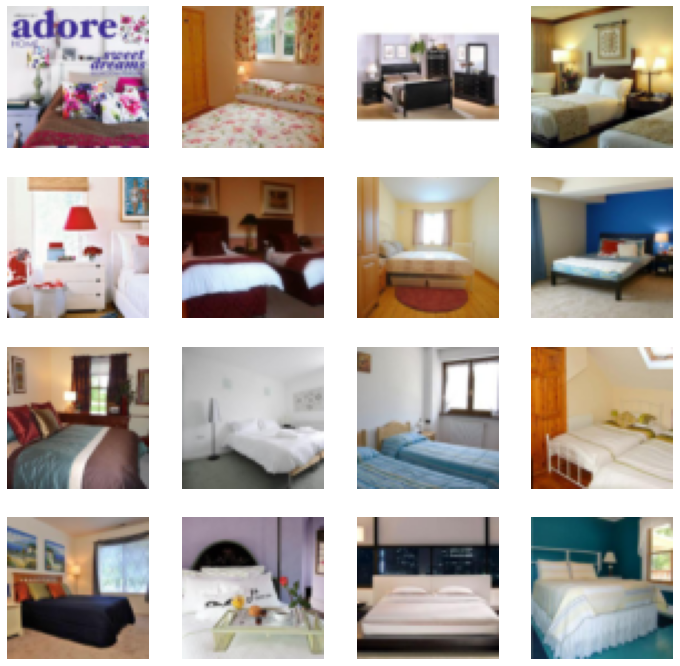

In [7]:
dls.show_batch(max_n=16)

In [8]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [9]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [10]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [13]:
learn.fit(30, 2e-4, wd=0.)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.669174,0.572872,-1.035063,10:58
1,-0.606571,0.487399,-0.894521,05:12
2,-0.546951,0.404367,-0.778501,05:13
3,-0.532423,0.337523,-0.718906,05:12
4,-0.462601,0.328441,-0.675115,05:10
5,-0.460257,0.291870,-0.619968,05:12
6,-0.404392,0.266167,-0.561402,05:13
7,-0.364402,0.242069,-0.515420,05:11
8,-0.342390,0.195715,-0.470253,05:13
9,-0.343882,0.186297,-0.435740,05:12


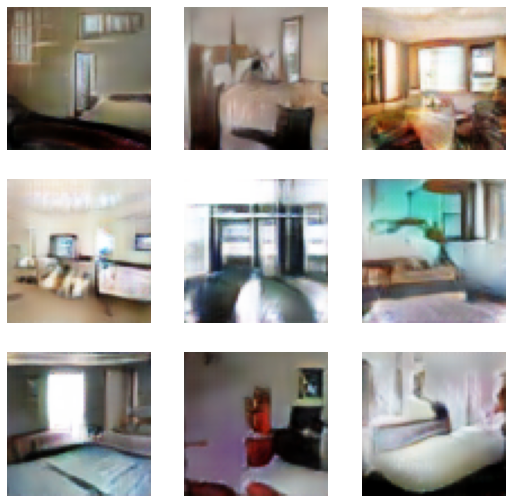

In [14]:
learn.show_results(max_n=9, ds_idx=0)

Okay. So, my attempt at making images from pictures of earth didn't work, but the demo does. The main difference is that the demo has literally 300k files, my earth data has 500. Let's see if adding more data fixes the problem. I took a 2.5 minute video of earth from space and decomposed it to it's individual jpgs. that got me about 5000 images. That seemed to be better, so I grabbed a 1-hour video and decomponsed that into about 85,000 images. Let's see if that trains better. So we're going to start over:

It's also worth noting that the 2.5 minute video changed the view of the planet partway through: it had some weird 3-dot display on the side for 30 seconds in the middle, and then did a sunset behind the planet at the end. That's all working against getting a good picture of the planet, so I had to remove those. That brought the 2.5 minute video data set down to a bit above 4,000 images. 

The one-hour one as a single-view of one entire rotation of the planet with clouds. But, you need to look at the images to make sure they're really a useful thing you want to be simulating.

In [2]:
path = Path("/home/g-clef/local_ml_data_copy/Planets/earth_movies")

In [3]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]))

In [4]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
    return dblock.dataloaders(path, path=path, bs=bs)
dls = get_dls(128, 64)

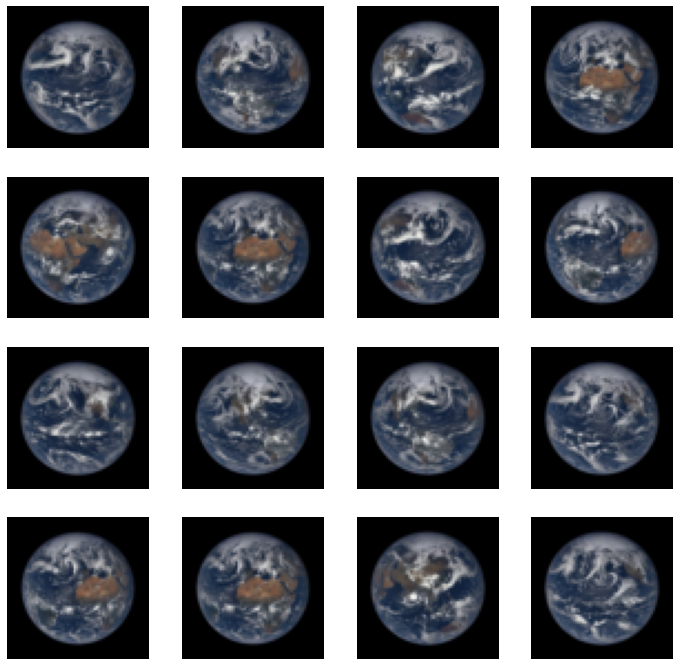

In [5]:
dls.show_batch(max_n=16)

In [6]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [7]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [8]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [9]:
learn.fit(30, wd=0.)

/home/g-clef/anaconda3/lib/python3.8/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/g-clef/anaconda3/lib/python3.8/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/g-clef/anaconda3/lib/python3.8/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,-0.544058,0.334824,-0.730458,20:02
1,-0.339587,0.432461,-0.819432,19:06
2,-0.389021,0.327128,-0.595628,18:22
3,-0.333703,0.239830,-0.479226,18:03
4,-0.325407,0.278051,-0.459017,18:05
5,-0.312975,0.239528,-0.405079,18:03
6,-0.290806,0.217783,-0.378486,19:20
7,-0.268257,0.223804,-0.384322,18:19
8,-0.341453,0.293069,-0.418536,17:42
9,-0.341044,0.309375,-0.463482,17:33


/home/g-clef/anaconda3/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


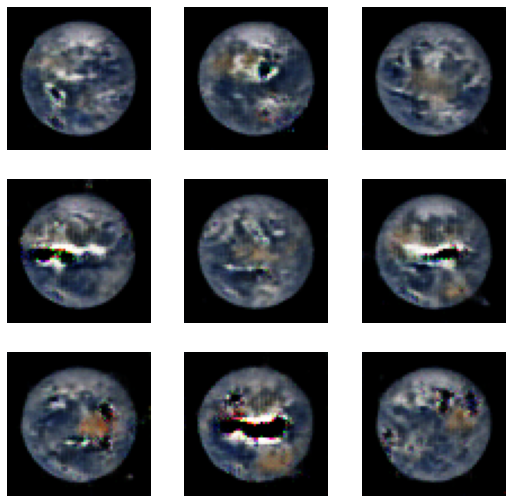

In [10]:
learn.show_results(max_n=9, ds_idx=0)

That's close to *very* good. There's weird tearing in the middle of the images, which I don't understand. I'll want to re-try that with different #'s of epochs to see if it's over- or under- trained. But overall, I'm happy with that...it's the first time I've seen real GAN-like results from my own dataset. 

one thing to learn from this iteration: the source images from the one-hour video were *big* - each image was almost 200kB, and there were 85,000 of them. That meant that each epoch in the training process was reading 15GB of images, and feeding them, one 200k file at a time, up to the video card. That meant the video card was not actually working very hard during this time because its input stream was starved for input by simple disk I/O. (This is partly because my linux rig is running on spinning rust HDs.) This might have been faster if I'd resized & shrunk the images before doing this training run.

In [12]:
learn.save("earth_30_epochs")

Path('/home/g-clef/local_ml_data_copy/Planets/earth_movies/models/earth_30_epochs.pth')

next steps:
 1. resize the images on disk to make them smaller...make the overall training faster.
 2. retry training with different # of epochs, to see if I can get tearing to go away.
 3. Try different learning models (train one, unfreeze lower layers, train again?)
 4. Figure out transfer learning (train on one image set, save model, change input data

Let's do #1 first: I resized all the earth images to 400x400, which shrank their overall size by a factor of 10. That will hopefully massively speed up training (possibly at the cost of accuracy, but I'll deal with that later). Those are stored in a sub-folder of earth_movies.

So, let's start over with teh smaller images:

In [18]:
path = Path("/home/g-clef/local_ml_data_copy/Planets/earth_movies/smaller_images")

In [19]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]))

In [20]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
    return dblock.dataloaders(path, path=path, bs=bs)
dls = get_dls(128, 64)

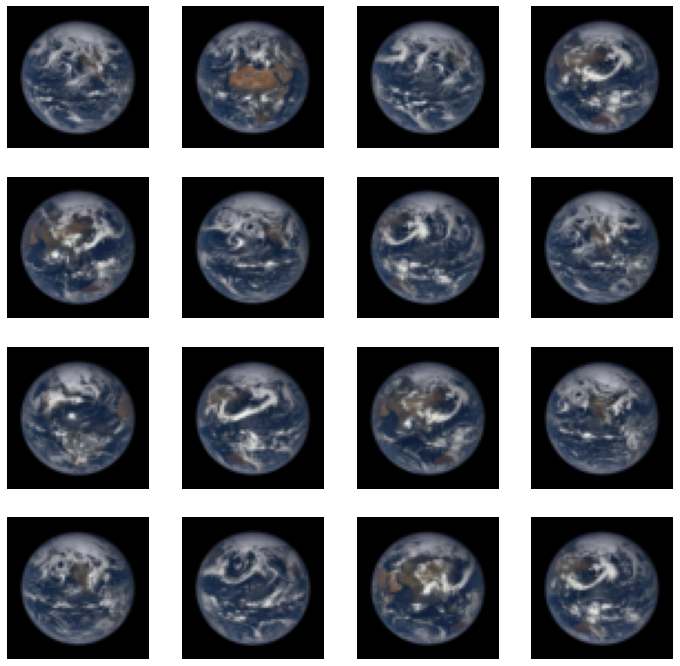

In [21]:
dls.show_batch(max_n=16)

In [22]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [23]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

In [24]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [25]:
learn.fit(20, wd=0.)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.340645,0.341539,-0.605090,01:58
1,-0.272998,0.231798,-0.465380,01:59
2,-0.314084,0.238215,-0.426576,01:58
3,-0.239063,0.250618,-0.376873,01:59
4,-0.304888,0.235932,-0.376105,01:59
5,-0.312811,0.258047,-0.404939,02:00
6,-0.324282,0.291029,-0.416397,01:59
7,-0.331193,0.296144,-0.442471,01:59
8,-0.338941,0.297708,-0.452670,01:59
9,-0.350378,0.297363,-0.467132,02:00


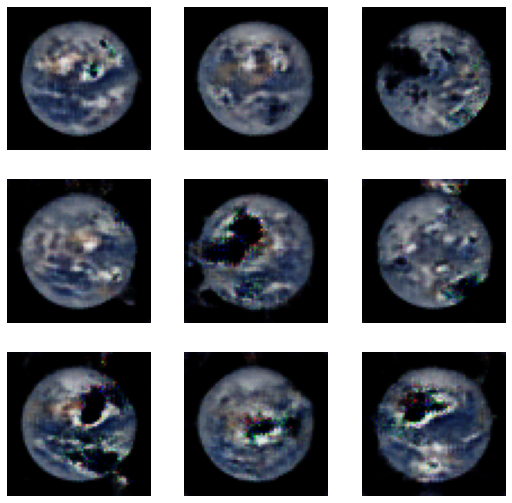

In [26]:
learn.show_results(max_n=9, ds_idx=0)

Not perfect, but similar to 30-epoch result, which says to me that the extra 10 epochs aren't making much difference. 

Independent of the results, the process here was much better: 2 minutes per epoch, the GPU was consistently loaded with data (GPU utilization was consistently 20-40% during training, with no periods of 0%, which it had last time). Also, each epoch of training got faster when I stopped & re-started the process after one epoch. I think the OS cached at least some of the images also, making feeding the GPU faster again. It may be worth making the image sizes match what the datablock generator is emitting, but I'm fine with 2 minutes per epoch here.

Let's try the fit(1), unfreeze, fit(10) pattern here.

In [27]:
path = Path("/home/g-clef/local_ml_data_copy/Planets/earth_movies/smaller_images")

In [28]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]))

In [29]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
    return dblock.dataloaders(path, path=path, bs=bs)
dls = get_dls(128, 64)

In [30]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [31]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [32]:
learn.fit(1)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.332264,0.269047,-0.556647,02:00


In [33]:
learn.unfreeze()

In [34]:
learn.fit(10)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.316737,0.100515,-0.352557,02:00
1,-0.346073,0.221687,-0.528915,02:00
2,-0.250380,0.162777,-0.382882,01:59
3,-0.304365,0.165169,-0.360578,02:00
4,-0.113003,0.116454,-0.314295,02:00
5,-0.092734,-0.017485,-0.117608,02:00
6,-0.266440,0.358707,-0.317067,01:59
7,-0.336498,0.443219,-0.465317,01:59
8,-0.327722,0.462917,-0.475050,01:59
9,-0.338641,0.466732,-0.482672,02:00


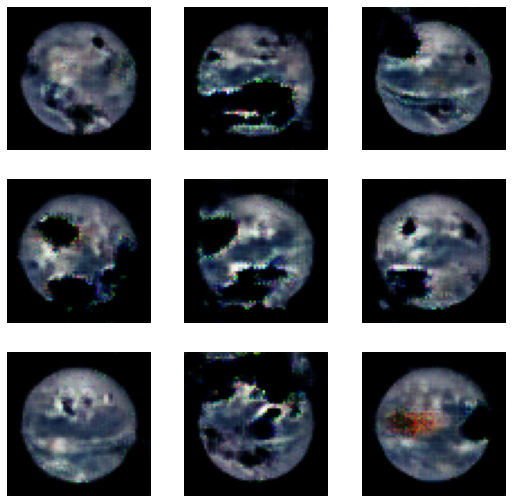

In [35]:
learn.show_results(max_n=9, ds_idx=0)

worse. Try 10 more epochs? or is it overfitting after 6 epochs?

In [36]:
learn.fit(10)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.317339,0.456347,-0.473154,02:00
1,-0.322443,0.451630,-0.469254,02:00
2,-0.306892,0.463569,-0.469183,02:00
3,-0.318437,0.463317,-0.468288,02:01
4,-0.319476,0.441481,-0.462251,02:00
5,-0.304770,0.446614,-0.457748,02:01
6,-0.306050,0.442017,-0.443433,02:00
7,-0.283304,0.434995,-0.438664,02:01
8,-0.297788,0.425920,-0.432551,02:00
9,-0.295353,0.428530,-0.430229,02:01


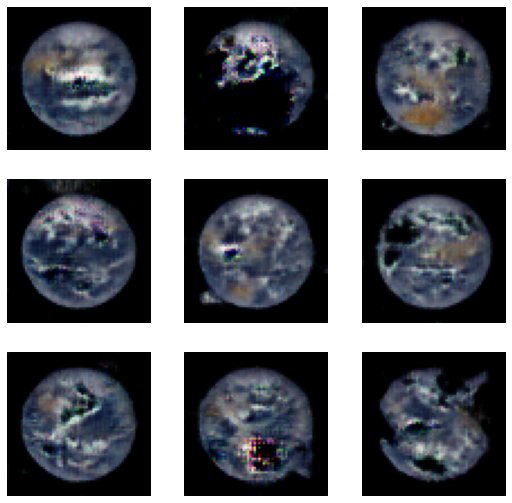

In [37]:
learn.show_results(max_n=9, ds_idx=0)

Better, but still lots of tearing and weird artifacts. The fact that they're better, though, makes me think that fewer epochs isn't the right answer...that was 20 epochs. try 30?

In [38]:
learn.fit(10)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.279659,0.431388,-0.430505,02:00
1,-0.293303,0.420006,-0.422753,02:00
2,-0.277396,0.416765,-0.417981,02:00
3,-0.287179,0.423449,-0.417655,02:00
4,-0.277955,0.427222,-0.414418,01:59
5,-0.271045,0.429504,-0.415495,01:59
6,-0.291744,0.422485,-0.415409,01:59
7,-0.286679,0.414667,-0.406326,02:00
8,-0.283709,0.414576,-0.399336,02:00
9,-0.270632,0.411055,-0.400161,01:59


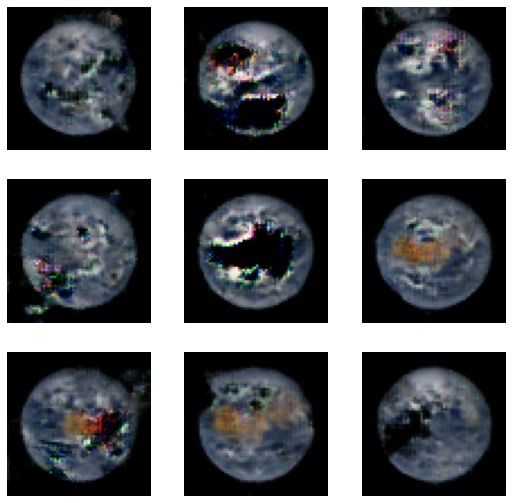

In [39]:
learn.show_results(max_n=9, ds_idx=0)

nope. Not any better. Let's try starting over and stopping after the 6th epoch, where the losses were all really small.

In [40]:
path = Path("/home/g-clef/local_ml_data_copy/Planets/earth_movies/smaller_images")
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]))
def get_dls(bs, size):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
    return dblock.dataloaders(path, path=path, bs=bs)
dls = get_dls(128, 64)
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [41]:
learn.fit(1)
learn.unfreeze()
learn.fit(6)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.422268,0.401371,-0.736075,02:00


epoch,train_loss,gen_loss,crit_loss,time
0,-0.385245,0.224601,-0.402461,02:00
1,-0.385332,0.268917,-0.520882,02:00
2,-0.304118,0.226587,-0.436666,02:00
3,-0.326694,0.205214,-0.417672,02:00
4,-0.335808,0.242304,-0.442787,02:00
5,-0.338537,0.263405,-0.455470,01:59


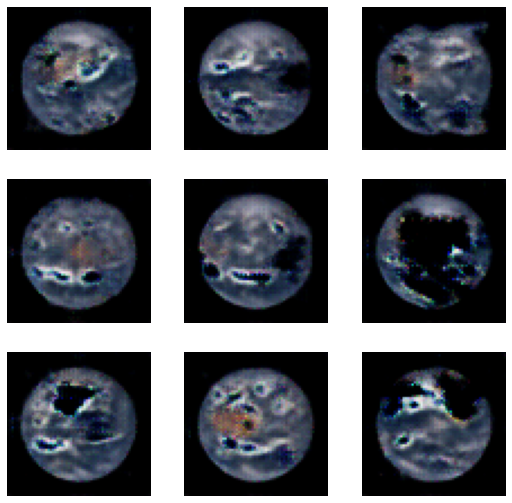

In [43]:
learn.show_results(max_n=9, ds_idx=0)

Still bad. Apparently FastAI is adapting its learning rate, so the magic 6th epoch doesn't do anything. 

Lets try the brute-force approach: don't unfreeze, run for 40 epochs. 

In [44]:
path = Path("/home/g-clef/local_ml_data_copy/Planets/earth_movies/smaller_images")
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]))
def get_dls(bs, size):
    dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))
    return dblock.dataloaders(path, path=path, bs=bs)
dls = get_dls(128, 64)
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [46]:
learn.fit(40)

epoch,train_loss,gen_loss,crit_loss,time
0,-0.338610,0.304367,-0.522407,02:01
1,-0.402700,0.284743,-0.520793,02:00
2,-0.306269,0.186625,-0.455521,02:00
3,-0.301824,0.228426,-0.408815,02:00
4,-0.284760,0.225799,-0.397660,02:00
5,-0.295643,0.235157,-0.398456,01:59
6,-0.337833,0.281956,-0.435724,01:59
7,-0.314125,0.284759,-0.457954,02:00
8,-0.350428,0.290513,-0.474872,02:00
9,-0.337083,0.321433,-0.450043,02:00


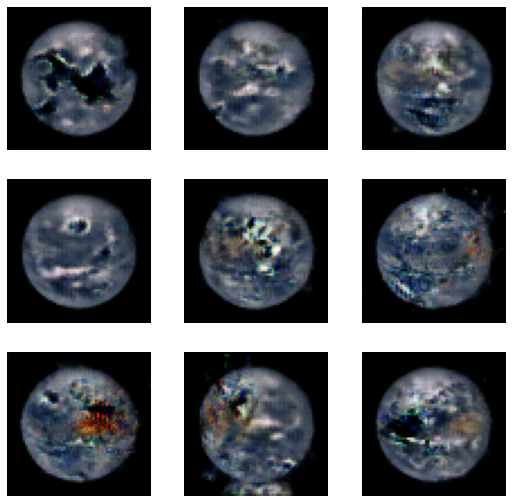

In [47]:
learn.show_results(max_n=9, ds_idx=0)

Still lots of tearing. It doesn't seem to be making a difference how long it trains for (well, past a certain point), nor freezing/unfreezing. But, one interesting thing is that the # of images does seem to make a difference: this is doing much better with 80k images than with 4k, and especially better than 500. This may be a simple factor of needing more input data...the one that worked had 300k images. 

Plan: make a 3-hour video of myself just doing stuff, and decompose that into separate images. If one hour gets me 80k images, 3 hours should be getting to the order of magnitude that the working example used.

Note: to avoid having the algorithm lock onto the background and becoming an "Aaron's Office" GAN, going to split this into multiple movies, each filmed from a different angle, so that I'm the only common factor in the images.